In [1]:
!pip install changeforest

In [7]:
import numpy as np
from changeforest import changeforest
from scipy.spatial.distance import cdist
from sklearn.metrics import adjusted_rand_score as sklearn_adjusted_rand_score
from tqdm import tqdm
import warnings
import plotly.graph_objects as go
warnings.filterwarnings('ignore')

In [8]:
dataset_generator = np.random.default_rng(12)

# Rand Index and Adjusted Rand index

The Rand Index computes a similarity measure between two clusterings by considering all pairs of samples and counting pairs that are assigned in the same or different clusters in the predicted and true clusterings.

let $tp,fp,tn$ and $fn$ be true positive pairs,false positive pairs,true negative pairs and false negative pairs.Then,

$$ RI = \frac{tp+tn}{tp+tn+fp+fn}$$

The adjusted rand index is rand index adjusted for chance 

$$ ARI = 2 \times \frac{tp \times tn - fn \times fp}{(tp + fn) \times (fn + tn) + (tp + fp) \times (fp + tn)}$$

Function to caculate the same

```
def calculate_rand_index_and_adjusted_rand_index(y_true,y_pred):
  pairs = []
  for i in range(len(y_true)):
    for j in range(i+1,len(y_true)):
      pairs.append((i,j))
  tp,tn,fp,fn =0,0,0,0
  for i,j in pairs:
    if y_true[i] == y_true[j] and y[j]==y[i]:
      tp+=1
    elif y_true[i] != y_true[j] and y[j]!=y[i]:
      tn+=1
    elif y_true[i]==y_true[j] and  y[j]!=y[i]:
      fn+=1
    elif y_true[i]!=y_true[j] and y[j]==y[i]:
      fp+=1
  rand_index = (tp+tn)/ (tp+tn+fp+fn)
  adjusted_rand_index = 2.0 * (tp * tn - fn * fp) / ((tp + fn) * (fn + tn) + (tp + fp) * (fp + tn))
  return rand_index,adjusted_rand_index

```

or you can use 
```
sklearn.metrics.adjusted_rand_score
```



In [16]:
def adjusted_rand_score(true_changepoints, estimated_changepoints):
    """Compute the adjusted rand index between two sets of changepoints.

    Args:
      true_changepoints (List) : list of true change points.
      estimated_changepoints (List) : list of estimated change points.
    """
    true_changepoints = np.array(true_changepoints, dtype=np.int_)
    estimated_changepoints = np.array(estimated_changepoints, dtype=np.int_)

    y_true = np.zeros(true_changepoints[-1])
    for i, (start, stop) in enumerate(zip(true_changepoints[:-1], true_changepoints[1:])):
        y_true[start:stop] = i

    y_estimated = np.zeros(estimated_changepoints[-1])
    for i, (start, stop) in enumerate(zip(estimated_changepoints[:-1], estimated_changepoints[1:])):
        y_estimated[start:stop] = i

    return sklearn_adjusted_rand_score(y_true, y_estimated)

# Change in Mean

In this experiment, I will perform change point detection on a generated dataset drawn from a set of normal distribution with different means. The number of observations  (n)  is 600, and the number of features is 5.

### Dataset
The dataset consisted of segments 1, 2 and 3 concatenated in that order.

* Segment 1 and segment 3 are both drawn from a normal distribution with $n=200$ mean $=0$ and std $=1$.
* segment 2 is drawn from normal distribution with $n=200$, mean $=2$ and std $=1$.
* Changes in mean occur at $t=200$ and $t=400$.

### Mean Calculation

Mean is the measure of central tendency of data.

$$ Mean(x) = E(x) \\ \\ \text{where} \ x \ \text{is a random variable.}$$

For descrite random varaiables the equation can be rewritten as

$$ Mean(x) = \frac{\Sigma_{i=1}^{n} x_{i}}{n} \\ \\ \text{where} \ x \ \text{is a random variable.} $$

In [5]:
def generate_change_in_mean_data(dataset_generator,n=600,d=5,mu=2):
  X = dataset_generator.normal(0, 1, (n, d))
  X[int(n / 3) : int(2 * n / 3), :] += mu
  orginal_change_points = [0, n / 3, 2 * n / 3, n]
  return X,orginal_change_points

In [6]:
X,orginal_change_points = generate_change_in_mean_data(dataset_generator)

In [7]:
result = changeforest(X, "random_forest", "bs")

In [8]:
result

                    best_split max_gain p_value
(0, 600]                   200   77.798   0.005
 ¦--(0, 200]                 6    -1.95    0.67
 °--(200, 600]             400  242.923   0.005
     ¦--(200, 400]         224   -6.764    0.82
     °--(400, 600]         412   -9.047    0.66

In [9]:
result.split_points()

[200, 400]

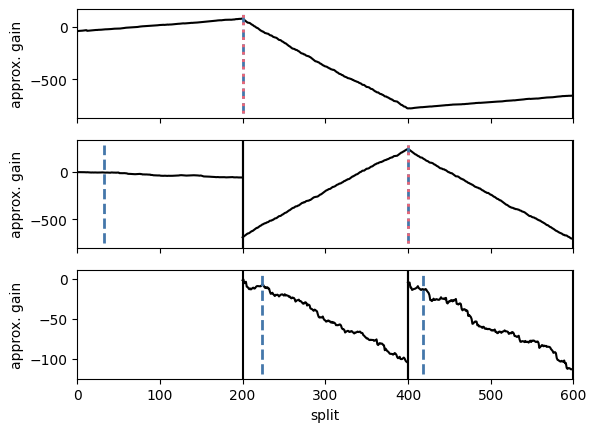

In [12]:
result.plot().show()

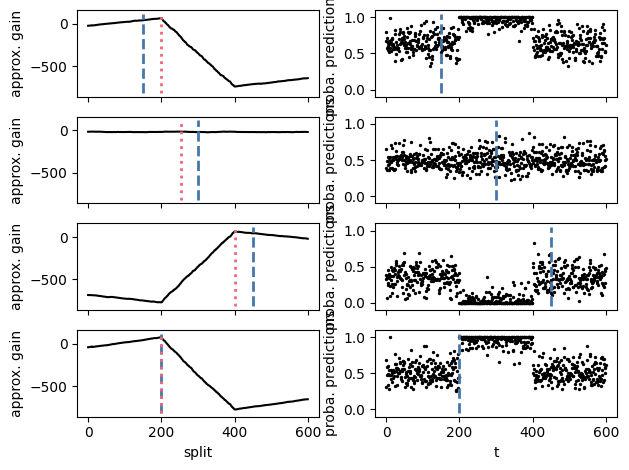

In [14]:
result.optimizer_result.plot().show()

In [13]:
pbar = tqdm(total=500)
pbar.set_description("Simulating Change in Mean: ")
ari_change_in_mean = []

for i in range(500):
  X,orginal_change_points = generate_change_in_mean_data(dataset_generator)
  result = changeforest(X, "random_forest", "bs")
  estimated_changepoints =[0] + result.split_points()+[600]
  score = adjusted_rand_score(orginal_change_points,estimated_changepoints)
  ari_change_in_mean.append(score)
  pbar.update(1)
pbar.close()

Simulating Change in Mean: : 100%|██████████| 500/500 [01:26<00:00,  5.77it/s]


In [14]:
np.mean(ari_change_in_mean),np.var(ari_change_in_mean)

(0.9855944462905414, 0.0012398515820303015)

In [17]:
fig = go.Figure()
steps =  list(range(1,501))
fig.add_trace(go.Scatter(x=steps, y=ari_change_in_mean,
                    mode='lines',
                    name='ARI Score'))
fig.add_trace(go.Scatter(x=steps, y=[np.mean(ari_change_in_mean)]*500,
                    mode='lines',
                    name='Mean ARI Score'))

fig.update_layout(
    title="Change in Mean",
    xaxis_title="Experiment Number",
    yaxis_title="ARI Score"
    )

fig.write_html("fig1.html", include_plotlyjs='cdn') 

Click [here](https://wajidmanzoor.github.io/Change-Point-detection-using-Random-Forest/notebooks/fig1.html) to check the above graph for change in mean simmulations

# Change in Variance
In this experiment, I will perform change point detection on a generated dataset drawn from a set of normal distributions with different variances. The number of observations $(n)$ is 600, and the number of features is 5.

### Dataset details
The dataset consists of segments 1,2 and 3 concatenated in that order.


* Segment 1 and segment 3 are both drawn from normal distribution with $n = 200$, mean $= 0$ and std $= 1$
* Segment 2 is drawn from normal distribution with $n = 200$, mean $= 0$ and std $= 3$.
* Change in Vairance occurs at $t=200$ and $t=400$.


### Vairance Calculation

Variance is a expcted value of squared devaition from the mean.

$$ Var(x) = E[(x-\bar{x})^{2}]$$

For descrite varaible the equation can be rewriten as 

$$ Var(x) = \frac{\Sigma_{i=1}^{n} (x_{i}-\bar{x})^{2}}{n-1} \\ \text{where} \ x \ \text{is a random variable.} $$



In [4]:
def generate_change_in_variance(dataset_generator,n=600,d=5,std=[1,3,1]):
  segment_1 = dataset_generator.normal(0,std[0],(n//3,d))
  segment_2 = dataset_generator.normal(0,std[1],(n//3,d))
  segment_3 = dataset_generator.normal(0,std[0],(n//3,d))
  X = np.concatenate( (segment_1,segment_2,segment_3,),axis=0,)
  return X,[0,200,400,n]

In [5]:
X,orginal_change_points = generate_change_in_variance(dataset_generator)

In [6]:
result = changeforest(X,"random_forest", "bs")

In [7]:
result

                    best_split max_gain p_value
(0, 600]                   401   69.778   0.005
 ¦--(0, 401]               199  194.459   0.005
 ¦   ¦--(0, 199]             6   -4.858   0.315
 ¦   °--(199, 401]         224   -6.607    0.81
 °--(401, 600]             417  -15.987   0.985

In [8]:
result.split_points()

[199, 401]

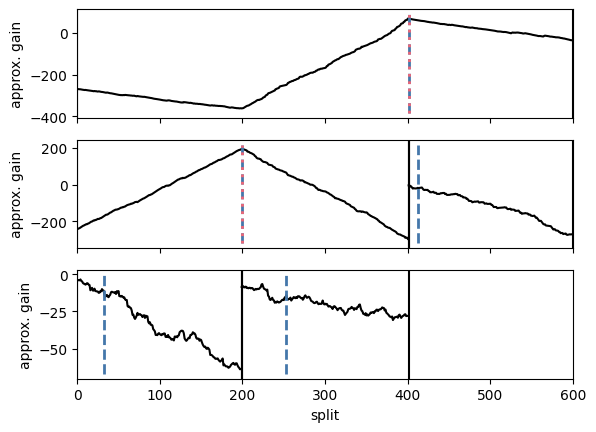

In [9]:
result.plot().show()

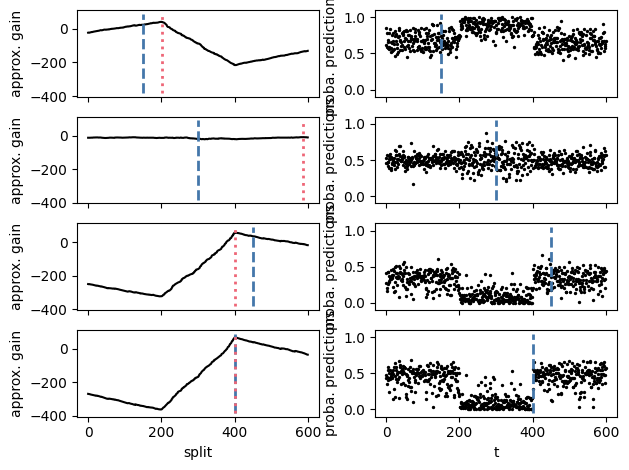

In [10]:
result.optimizer_result.plot().show()

In [11]:
pbar = tqdm(total=500)
pbar.set_description("Simulating Change in Variance: ")
ari_change_in_variance = []

for i in range(500):
  X,orginal_change_points = generate_change_in_variance(dataset_generator)
  result = changeforest(X, "random_forest", "bs")
  estimated_changepoints =[0] + result.split_points()+[600]
  score = adjusted_rand_score(orginal_change_points,estimated_changepoints)
  ari_change_in_variance.append(score)
  pbar.update(1)
pbar.close()

Simulating Change in Variance: : 100%|██████████| 500/500 [01:27<00:00,  5.74it/s]


In [12]:
np.mean(ari_change_in_variance),np.var(ari_change_in_variance)

(0.9843695221982109, 0.001232354575340596)

In [16]:
fig = go.Figure()
steps =  list(range(1,501))
fig.add_trace(go.Scatter(x=steps, y=ari_change_in_variance,
                    mode='lines',
                    name='ARI Score'))
fig.add_trace(go.Scatter(x=steps, y=[np.mean(ari_change_in_variance)]*500,
                    mode='lines',
                    name='Mean ARI Score'))

fig.update_layout(
    title="Change in Variance",
    xaxis_title="Experiment Number",
    yaxis_title="ARI Score"
    )

fig.write_html("fig2.html")

To see the above change in variance graph click [here](https://wajidmanzoor.github.io/Change-Point-detection-using-Random-Forest/notebooks/fig2.html)

# Change in Covarince
In this experiment, I will perform change point detection on a generated dataset drawn from a set of normal distributions with different covariances. The number of observations $(n)$ is 600, and the number of features is 5.

### Dataset details
The dataset consists of segments 1,2 and 3 concatenated in that order.


* Segment 1 and segment 3 are both drawn from normal distribution with $n = 200$, mean $= 0$ and std $= 1$
* Segment 2 is drawn from normal distribution with $n = 200$, mean $= 0$, std $= 1$ and covaraince $=0.7$ between any two features
* Change in covairance occurs at $t=200$ and $t=400$.


### Covairance Calculation

Covaiance is the measure of joint varabilty of two random varaibales

$$ cov(a,b) = E[(x-E[x]) \times (y-E[y])] \\ \\  \text{where} \ x \ \text{and} \ y \ \text{are random varaibles}$$

For Discreate random varaibles the above equation can be rewritten as

$$ cov(a,b) = \frac{\Sigma_{i=1}^{n} (x_{i} - \bar{x} ) \times (y_{i} - \bar{y})}{n-1} \\ \\ \text{where} \ \bar{x} \ \text{and} \ \bar{y} \text{ are sample means of random varaible} \  x \ \text{and} \  y \ \text{respectively.}$$

In [17]:
def generate_change_in_covariance(dataset_generator,n=600,d=5,rho=0.7):
  Sigma = np.full((d, d), rho)
  np.fill_diagonal(Sigma, 1)
  segment_1 = dataset_generator.normal(0, 1, (n//3, d))
  segment_2 = dataset_generator.multivariate_normal(np.zeros(d),Sigma,n//3,method='cholesky')
  segment_3 = dataset_generator.normal(0, 1, (n//3, d))
  X = np.concatenate( (segment_1,segment_2,segment_3,),axis=0,)
  orginal_change_points = [0,200,400,n]
  return X,orginal_change_points

In [18]:
X,orginal_change_points = generate_change_in_covariance(dataset_generator)

In [19]:
result = changeforest(X,"random_forest","bs")

In [20]:
result

                    best_split max_gain p_value
(0, 600]                   200   13.326   0.005
 ¦--(0, 200]                11   -8.644    0.64
 °--(200, 600]             400   69.434   0.005
     ¦--(200, 400]         393  -11.271    0.99
     °--(400, 600]         588  -11.105    0.98

In [21]:
result.split_points()

[200, 400]

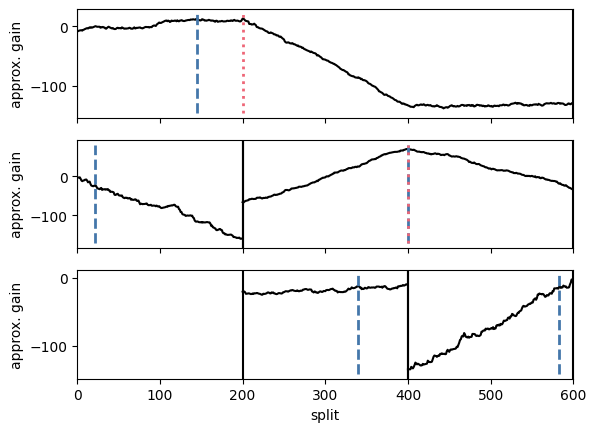

In [22]:
result.plot().show()

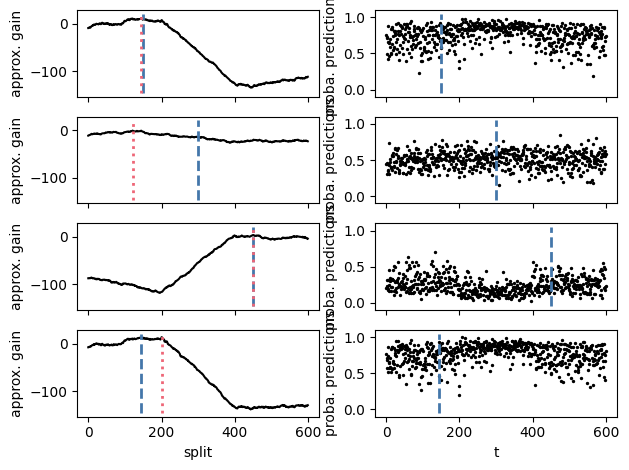

In [24]:
result.optimizer_result.plot().show()

In [25]:
pbar = tqdm(total=500)
pbar.set_description("Simulating Change in Covarince: ")
ari_change_in_covariance = []

for i in range(500):
  X,orginal_change_points = generate_change_in_covariance(dataset_generator)
  result = changeforest(X, "random_forest", "bs")
  estimated_changepoints =[0] + result.split_points()+[600]
  score = adjusted_rand_score(orginal_change_points,estimated_changepoints)
  ari_change_in_covariance.append(score)
  pbar.update(1)
pbar.close()

Simulating Change in Covarince: : 100%|██████████| 500/500 [01:28<00:00,  5.68it/s]


In [26]:
np.mean(ari_change_in_covariance),np.var(ari_change_in_covariance)

(0.9237564020144002, 0.020253540945444355)

In [28]:
fig = go.Figure()
steps =  list(range(1,501))
fig.add_trace(go.Scatter(x=steps, y=ari_change_in_covariance,
                    mode='lines',
                    name='ARI Score'))
fig.add_trace(go.Scatter(x=steps, y=[np.mean(ari_change_in_covariance)]*500,
                    mode='lines',
                    name='Mean ARI Score'))

fig.update_layout(
    title="Change in Covariance",
    xaxis_title="Experiment Number",
    yaxis_title="ARI Score"
    )

fig.write_html("fig3.html")

Click [here](https://wajidmanzoor.github.io/Change-Point-detection-using-Random-Forest/notebooks/fig3.html) to see the plot of change in covariance simulation.

# Dirichlet Distribution

In [1]:
def generate_dirichlet(dataset_generator,d=20,changepoints=[0, 100, 130, 220, 320, 370, 520, 620, 740, 790, 870, 1000]):
  n_segments = len(changepoints) - 1
  params = dataset_generator.uniform(0, 0.2, n_segments * d).reshape((n_segments, d))

  X = np.zeros((changepoints[-1], d))
  for idx, (start, end) in enumerate(zip(changepoints[:-1], changepoints[1:])):
      X[start:end, :] = dataset_generator.dirichlet(params[idx, :], end - start)
  return X,changepoints

In [9]:
X,orginal_change_points = generate_dirichlet(dataset_generator)

In [10]:
result = changeforest(X,"random_forest", "bs")

In [11]:
result

                                best_split max_gain p_value
(0, 1000]                              740  355.587   0.005
 ¦--(0, 740]                           370  308.355   0.005
 ¦   ¦--(0, 370]                       100  177.837   0.005
 ¦   ¦   ¦--(0, 100]                    21   -4.453   0.865
 ¦   ¦   °--(100, 370]                 220  118.586   0.005
 ¦   ¦       ¦--(100, 220]             130   57.732   0.005
 ¦   ¦       ¦   ¦--(100, 130]         112   -1.556   0.265
 ¦   ¦       ¦   °--(130, 220]         206     1.01   0.665
 ¦   ¦       °--(220, 370]             320   76.196   0.005
 ¦   ¦           ¦--(220, 320]         309   -4.161   0.995
 ¦   ¦           °--(320, 370]         334    3.415   0.315
 ¦   °--(370, 740]                     620  181.162   0.005
 ¦       ¦--(370, 620]                 520   145.11   0.005
 ¦       ¦   ¦--(370, 520]             391  -11.707   0.275
 ¦       ¦   °--(520, 620]             531   -1.762    0.68
 ¦       °--(620, 740]                 6

In [12]:
result.split_points()

[100, 130, 220, 320, 370, 520, 620, 740, 790, 870]

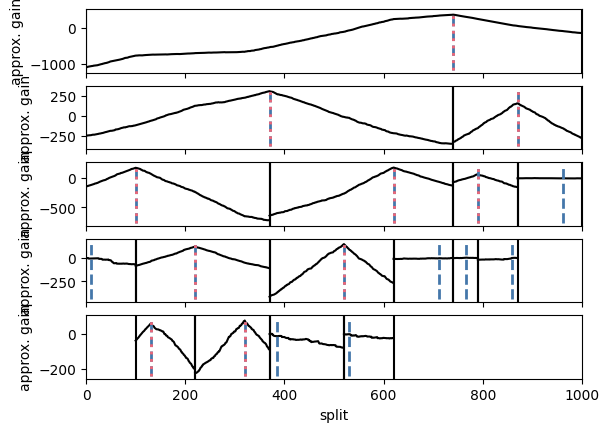

In [13]:
result.plot().show()

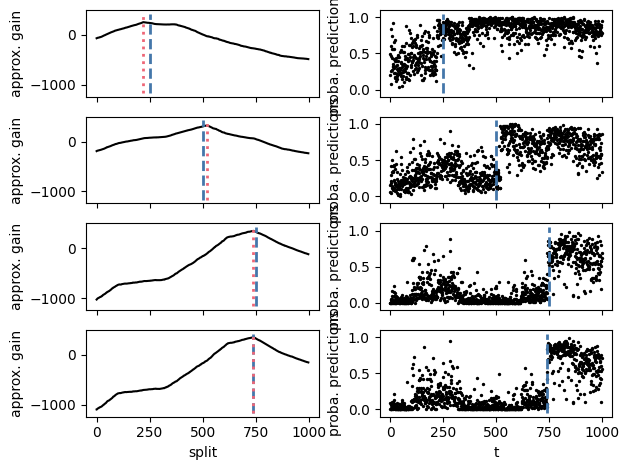

In [14]:
result.optimizer_result.plot().show()

In [23]:
pbar = tqdm(total=500)
pbar.set_description("Simulating Change in Dirichlet: ")
ari_dirichlet = []

for i in range(500):
  X,orginal_change_points = generate_dirichlet(dataset_generator)
  result = changeforest(X, "random_forest", "bs")
  estimated_changepoints =[0] + result.split_points()+[1000]
  score = adjusted_rand_score(orginal_change_points,estimated_changepoints)
  ari_dirichlet.append(score)
  pbar.update(1)
pbar.close()

Simulating Change in Dirichlet: : 100%|██████████| 500/500 [08:22<00:00,  1.01s/it]


In [24]:
np.mean(ari_dirichlet),np.var(ari_dirichlet)

(0.9853855826314857, 0.00034421374137049386)

In [25]:
fig = go.Figure()
steps =  list(range(1,501))
fig.add_trace(go.Scatter(x=steps, y=ari_dirichlet,
                    mode='lines',
                    name='ARI Score'))
fig.add_trace(go.Scatter(x=steps, y=[np.mean(ari_dirichlet)]*500,
                    mode='lines',
                    name='Mean ARI Score'))

fig.update_layout(
    title="Dirichlet",
    xaxis_title="Experiment Number",
    yaxis_title="ARI Score"
    )

fig.write_html("fig4.html")

Click [here](https://wajidmanzoor.github.io/Change-Point-detection-using-Random-Forest/notebooks/fig4.html) to see the above dirichlet simulation results.